# Geo Time Series to Image

This notebook shows some examples of how to use the package geots2img.

---

In [1]:
# Standard libraries
import pandas as pd

# Import this package
from geots2img import ImageGenerator
from geots2img import generate_image_sequence, generate_video

# Enable modules to be reloaded during development
%load_ext autoreload
%autoreload 2

---

### Set some parameters

These are parameters that define that define the region we will use as an example -- they are relevant to the example data provided.

Throughout this notebook we'll use latitute and longitude -- but the package can be used in the exact same way for any sets of x and y coordinates.

In [2]:
LAT_RANGE = [-32, -31.8]
LON_RANGE = [115.7, 115.9]

GEO_RES = 0.0005

---

### Load temperature data

Some example data has been provided (in the same directory as this notebook).  The example data consists of hourly temperature measurements at 29 postcodes in Western Australia on 1 November 2020.

In [3]:
data = pd.read_csv('example_data.csv')

In [4]:
# Convert timestamp column to timestamp objects,
# and set as index of the data frame
data['timestamp'] = [pd.Timestamp(x) for x in data['timestamp']]
data.set_index('timestamp', inplace = True)

In [5]:
# Let's check out a subset of the data
data.iloc[5:10, 5:10]

,6090,6061,6018,6029,6019
timestamp,,,,,
2020-11-01 05:00:00+08:00,17.0,17.0,17.0,17.0,17.0
2020-11-01 06:00:00+08:00,16.0,16.0,16.0,16.0,16.0
2020-11-01 07:00:00+08:00,16.0,16.0,16.0,16.0,16.0
2020-11-01 08:00:00+08:00,16.0,16.0,15.0,15.0,15.0
2020-11-01 09:00:00+08:00,15.0,15.0,15.0,15.0,15.0


In [6]:
# We need to scale these values to range [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(data.to_numpy().reshape(-1,1)) 
data.loc[:,:] = scaled_values.reshape(len(data), -1)
data.iloc[5:10, 5:10]

,6090,6061,6018,6029,6019
timestamp,,,,,
2020-11-01 05:00:00+08:00,0.666667,0.666667,0.666667,0.666667,0.666667
2020-11-01 06:00:00+08:00,0.500000,0.500000,0.500000,0.500000,0.500000
2020-11-01 07:00:00+08:00,0.500000,0.500000,0.500000,0.500000,0.500000
2020-11-01 08:00:00+08:00,0.500000,0.500000,0.333333,0.333333,0.333333
2020-11-01 09:00:00+08:00,0.333333,0.333333,0.333333,0.333333,0.333333


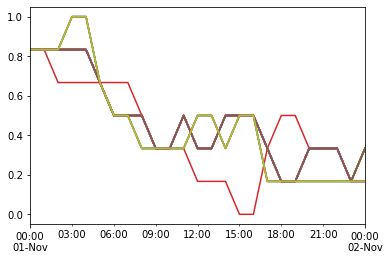

In [29]:
# We can also quickly plot these to get a sense of the data
ax = data.plot(legend=False, xlabel="");
fig = ax.get_figure()
fig.savefig('example_data.png')

In [8]:
# Let's also store the postcodes for convenience
postcodes = list(data.columns)

---

### Load geospatial coordinates

There is another csv file that contains the latitudes and longitudes of the approximate centers of these postcodes.

In [9]:
latlons = pd.read_csv('example_latlons.csv')

In [10]:
# Make postcodes strings and set as index
latlons['postcode'] = latlons['postcode'].astype(str)
latlons.set_index('postcode', inplace = True)

In [11]:
# Check first five
latlons[:5]

,lat,lon
postcode,,
6023,-31.831300,115.775705
6024,-31.831328,115.806460
6064,-31.833288,115.851268
6020,-31.845285,115.755612
6066,-31.840688,115.898017


---

### Generate single image

Let's now explore some options for generating an image for one specific interval

In [12]:
# The interval for which to generate an image
from dateutil import parser
DATETIME = parser.parse('2020-11-01 12:00:00+08:00')

In [13]:
# Generate lists of source data points and values
source_points = []
source_values = []
for pc in postcodes:
    [lon, lat] = latlons.loc[pc, ['lon', 'lat']]
    value = data.loc[DATETIME, pc]
    source_points.append((lon, lat))
    source_values.append(value)

# Display five example points and values
print(source_points[5:10])
print(source_values[5:10])

[(115.89198859553905, -31.86042093433865), (115.84956244168356, -31.863476736936537), (115.78734936746204, -31.884060853496027), (115.75621147093167, -31.876142476355472), (115.76771584016473, -31.901720233489826)]
[0.3333333333333335, 0.3333333333333335, 0.5, 0.5, 0.5]


In [14]:
# Create geots2img image generator object
image_gen = ImageGenerator(LON_RANGE, LAT_RANGE, GEO_RES)

In [15]:
# Set the source points and values
image_gen.set_source_points(source_points)
image_gen.set_source_values(source_values)

In [16]:
# Generate the image
image_gen.generate_image()

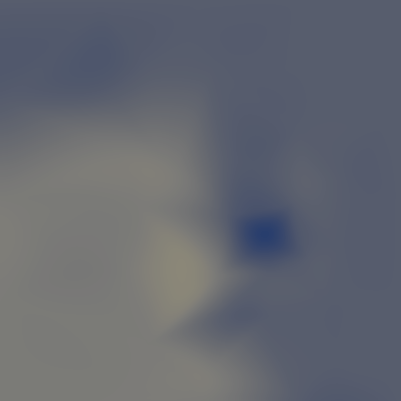

In [17]:
# Display the image
image_gen.image

---

### Customise single image

In the above example, all the default values were used.  However, we have several options to customise the image.


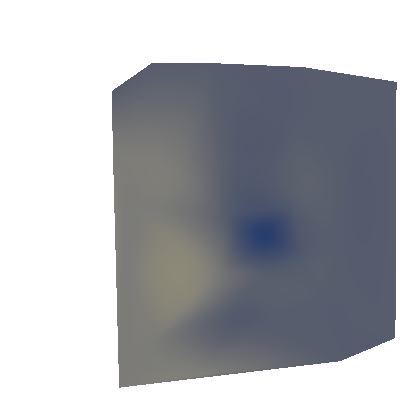

In [18]:
# Generate an image that does not include boundary points
image_gen.generate_image(include_boundary_points=False, refit=True)
image_gen.image

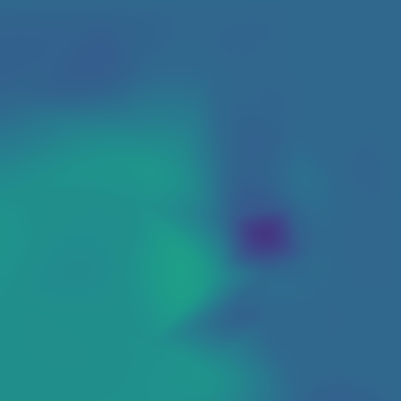

In [19]:
# Change the color map
import matplotlib.pyplot as plt
image_gen.set_color_map(plt.get_cmap('viridis'))
image_gen.generate_image(refit=True)
image_gen.image

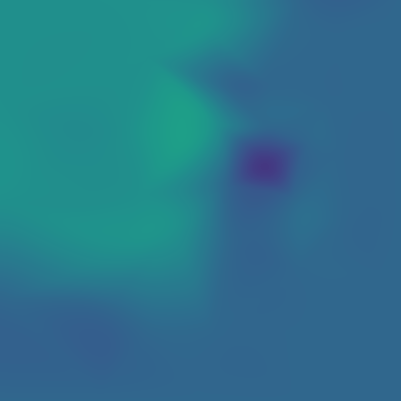

In [20]:
# Avoid flipping y axis
image_gen.generate_image(flip_y=False, refit=True)
image_gen.image

There may be many other custom visualisations that could be useful.  For example, we may want to include axes, labels, a figure title, markers for source and/or boundary points, etc.

For now, we recommend using another package (such as matplotlib.pyplot) for this purpose -- using images generated here as a background image.

One example of how this can be done is provided below.

In [31]:
# Reset image
image_gen = ImageGenerator(LON_RANGE, LAT_RANGE, GEO_RES)
image_gen.set_source_points(source_points)
image_gen.set_source_values(source_values)
image_gen.generate_image()

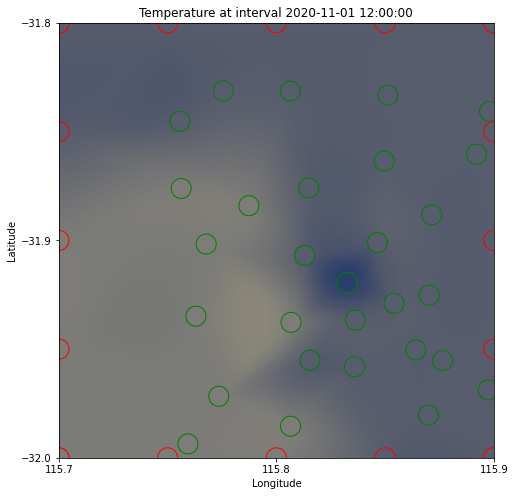

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[8, 8])

# Axes, title
ax.set_xlim(LON_RANGE)
ax.set_ylim(LAT_RANGE)
ax.set_title("Temperature at interval " + DATETIME.strftime('%Y-%m-%d %H:%M:%S'))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks([115.7, 115.8, 115.9]);
ax.set_yticks([-32.0, -31.9, -31.8]);

# Background image
ax.imshow(image_gen.image,
          extent=[
              LON_RANGE[0], LON_RANGE[1],
              LAT_RANGE[0], LAT_RANGE[1]
          ],
          alpha=1);

# Markers for source points
source_x = [p[0] for p in image_gen.source_points]
source_y = [p[1] for p in image_gen.source_points]
scatter = ax.scatter(source_x, source_y, s=400, c=image_gen.source_values, 
           cmap=image_gen.cmap, marker="o", edgecolors="green", 
           vmin=0, vmax=1);

# Markers for boundary points
boundary_x = [p[0] for p in image_gen.boundary_points]
boundary_y = [p[1] for p in image_gen.boundary_points]
ax.scatter(boundary_x, boundary_y, s=400, c=image_gen.boundary_values, 
           cmap=image_gen.cmap, marker="o", edgecolors="red", 
           vmin=0, vmax=1);

fig = ax.get_figure()
fig.savefig('example_image_annotated.png')

---

### Save image to file

Saving image to file is easy:

In [23]:
image_gen.save_image("example_image.png")

---

### Extract fitted values

For many applications we may not be interested in the visual image; rather, we want to use the values that result from fitting a surface to the source and boundary points.

We can retrieve the full 2D array covering the entire area.  It is important to remember that this is a grid specified by our `x_range` and `y_range`, having our specified `resolution`.

In [24]:
image_gen.fitted_values

array([[0.5       , 0.49995308, 0.49990619, ..., 0.33205151, 0.33269223,
        0.33333333],
       [0.49997454, 0.49992617, 0.49987728, ..., 0.33204574, 0.33269129,
        0.33333549],
       [0.49994909, 0.49989984, 0.49984953, ..., 0.33204375, 0.33269225,
        0.33333764],
       ...,
       [0.3326089 , 0.33275513, 0.33286945, ..., 0.33340146, 0.33340341,
        0.33340559],
       [0.33297641, 0.33308949, 0.33318075, ..., 0.33336366, 0.33336706,
        0.33336959],
       [0.33333333, 0.33342716, 0.33351784, ..., 0.33332742, 0.33333035,
        0.33333333]])

Alternatively, we can just retrieve values for a specific set of points:

In [25]:
# Get our original source points as an array of [(x, y), ... ]
points = []
for pc in postcodes:
    [lon, lat] = latlons.loc[pc, ['lon', 'lat']]
    points.append([lon, lat])

# Get fitted values for these specific points
fitted_point_values = image_gen.get_fitted_point_values(points)

# Display five example points
fitted_point_values[5:10]

[0.3333386138135418,
 0.3333115630265184,
 0.501987986506819,
 0.5010404612625529,
 0.4996633454362309]

---

### Generate sequence of images and/or video

Finally, we may want to generate a whole sequence of images, and we might want to convert these into a video.

In [26]:
# Create an image_generator object as before
image_gen = ImageGenerator(LON_RANGE, LAT_RANGE, GEO_RES)
image_gen.set_source_points(source_points)

Now let's generate a sequence of images using this image generator.  Note that we can specify time period and path to which images should be saved, if we want to.  Here we'll just use defaults.

In [27]:
generate_image_sequence(data, image_gen)

If you now navigate to the directory `examples/images`, you should find a set of images, one for each interval in the data.

These images can be converted into a video using any standard tools.  Some basic support for command line tool `ffmpeg` is provided with the python function below:

In [33]:
generate_video(
    source_path = 'images/', 
    target_path = 'example_video.gif', 
    frame_rate = 5,
    format = 'gif'
)

The generated video can be found at `examples/example_video.mp4`.

In this instance (one day of temperature data), it's not that interesting in the end -- although it does indicate that one postcode seems to have either faulty sensors or unique characteristics.  However, for other types of time series data (like solar PV generation, for example), these types of visualisation can be very helpful.